# Training Clip

- Test Clip using a test, eval dataset
    - Will use 3100 tweets(2600 train, 500 eval); then will try to cluster the rest of the tweets and check the results
    - Split dataset and save it into disk
    - Create a dataloader
    - Training Clip using CrossEntropy Loss in the top of img and txt embeddings
    - Check results

## Split dataset 

In [1]:
import pandas as pd
import os
import shutil
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
# read annotation
full_data = pd.read_pickle('../annotations/binary_annotation.pkl')


# Select balanced train data 
# here we are considering that if any modality is relevant than the tweet itself is relevant
positive_samples = full_data[(full_data['img'] == True) | (full_data['txt'] == True)].sample(1216, random_state=0)
negative_samples = full_data[(full_data['img'] == False) & (full_data['txt'] == False)].sample(1884, random_state=0)

use_data = pd.concat([positive_samples,negative_samples])

In [3]:
# Get all data and paste it into local dir
annotated_data = pd.read_pickle('../annotations/5k-data.pkl')

# Get the rest that will to test the clusters of the trained model
cluster_data =  pd.concat([full_data, use_data]).drop_duplicates(keep=False)
cluster_data = annotated_data.merge(cluster_data, how='inner', on='tweet_id', suffixes=('_path', '_label'))

In [4]:
# divide use_data into trainig and eval
train = use_data.sample(2600, random_state=0)
test = pd.concat([train, use_data]).drop_duplicates(keep=False)

<AxesSubplot:xlabel='img,txt'>

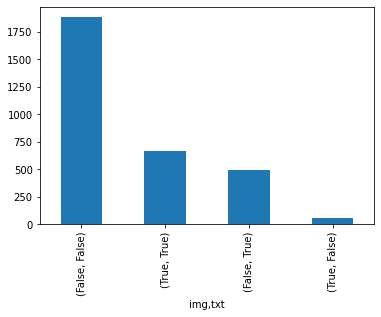

In [5]:
use_data[['img', 'txt']].value_counts().plot(kind='bar')

In [6]:
# Get data with annotations
train = annotated_data.merge(train, how='inner', on='tweet_id', suffixes=('_path', '_label'))
test = annotated_data.merge(test, how='inner', on='tweet_id', suffixes=('_path', '_label'))

# Save each type of data
train.to_pickle("train.pkl")
test.to_pickle("test.pkl")
cluster_data.to_pickle("cluster_data.pkl")

In [8]:
# Save images of each type of data
# train
for _, row in tqdm(train.iterrows(), total=len(train),desc='Copy Train'):
    src = '../annotations/'+ row['img_path']
    dest = 'train'
    os.makedirs(dest,exist_ok=True)
    dest = dest +'/'+ str(Path(row['img_path']).name) 
    shutil.copy(src,dest)

for _, row in tqdm(test.iterrows(), total=len(test),desc='Copy test'):
    src = '../annotations/'+ row['img_path']
    dest = 'test'
    os.makedirs(dest,exist_ok=True)
    dest = dest +'/'+ str(Path(row['img_path']).name) 
    shutil.copy(src,dest)
    
    
for _, row in tqdm(cluster_data.iterrows(), total=len(cluster_data),desc='Copy cluster_data'):
    src = '../annotations/'+ row['img_path']
    dest = 'cluster_data'
    os.makedirs(dest,exist_ok=True)
    dest = dest +'/'+ str(Path(row['img_path']).name) 
    shutil.copy(src,dest)

Copy Train:   0%|          | 0/2600 [00:00<?, ?it/s]

Copy test:   0%|          | 0/500 [00:00<?, ?it/s]

Copy not_use_data:   0%|          | 0/1900 [00:00<?, ?it/s]

----

# Dataloader

In [3]:
import pandas as pd
import preprocess as text_preprocess
from tqdm.notebook import tqdm
train_data = pd.read_pickle('train.pkl').rename(columns={'txt':'txt_label'})
eval_data = train_data.sample(200, random_state=0)
train_data = pd.concat([eval_data, train_data]).drop_duplicates(keep=False)


test_data = pd.read_pickle('test.pkl').rename(columns={'txt':'txt_label'})


In [4]:
train_imgs = []
train_txts = []
train_labels = []
for _, row in train_data.iterrows():
    
    train_imgs.append(row['img_path'].replace("annotated-data", "train"))
    # Applie Preprocess stage here
    train_txts.append(text_preprocess.pre_process(row['text'], keep_hashtag = True, keep_special_symbols = False))
    
    if row['img_label'] or row['txt_label']:
        train_labels.append(1)
    else:
        train_labels.append(0)
    
eval_imgs = []
eval_txts = []
eval_labels = []
for _, row in eval_data.iterrows():
    
    eval_imgs.append(row['img_path'].replace("annotated-data", "train"))
    # Applie Preprocess stage here
    eval_txts.append(text_preprocess.pre_process(row['text'], keep_hashtag = True, keep_special_symbols = False))
    
    if row['img_label'] or row['txt_label']:
        eval_labels.append(1)
    else:
        eval_labels.append(0)
       
    
test_imgs = []
test_txts = []
test_labels = []
for _, row in test_data.iterrows():
    
    test_imgs.append(row['img_path'].replace("annotated-data", "test"))
    # Applie Preprocess stage here
    test_txts.append(text_preprocess.pre_process(row['text'], keep_hashtag = True, keep_special_symbols = False))
    
    if row['img_label'] or row['txt_label']:
        test_labels.append(1)
    else:
        test_labels.append(0)
        


In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import clip
from PIL import Image
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
IMG_FORMATS = ['JPG','JPEG', 'PNG', 'BMP', 'MPO', 'PPM', 'TIFF', 'GIF']

device = "cuda:1" if torch.cuda.is_available() else "cpu"

# load model and image preprocessing
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

class CLIPDataset(Dataset):
    """
    Dataset of Img and Text associated with an Tweet to be processed by CLIP
    """
   
    def __init__(self,
                 image_files,
                 texts,
                 tokenizer,
                 image_preprocess,
                 labels,
                 device
    ):
        
        self.image_preprocess = image_preprocess
        self.text_preprocess = text_preprocess
        self.image_files = image_files
        self.images = [self.image_preprocess(self.load_image(i)) for i in tqdm(self.image_files)]
        self.texts = texts
        self.tokenizer = tokenizer
       
        labels = [ (1,0) if l else (0,1) for l in labels ]
        self.labels = torch.tensor(labels).unsqueeze(dim=1).type(torch.half)
        self.device = device

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image
        image = self.images[idx]
        preprocessed_img = image.to(device)
        
        # Get Text
        text = self.texts[idx]
        preprocess_text = self.text_preprocess.pre_process(text)
        preprocess_text = self.tokenizer(preprocess_text, context_length=77, truncate=True).squeeze().to(device)
        
        # Get Ground-truth
        gt =  self.labels[idx].squeeze().to(device)  # 1 relevant, 0 not relevant
                                                 
                                                 
        return preprocessed_img, preprocess_text, gt
    
    
    def load_image(
        self,
        image_file,
        target_size= None,
        grayscale = False,
        img_formats = IMG_FORMATS,
    ):
        """
        Load an image given its path. Returns an array version of optionally resized and grayed image. Only allows images
        of types described by img_formats argument.
        Args:
            image_file: Path to the image file.
            target_size: Size to resize the input image to.
            grayscale: A boolean indicating whether to grayscale the image.
            img_formats: List of allowed image formats that can be loaded.

        Original Method from https://github.com/idealo/imagededup/blob/3465540cc5c8fdf9254aff76069e28641dfc515f/imagededup/utils/image_utils.py
        """
        try:
            img = Image.open(image_file)

            # validate image format
            if img.format not in img_formats:
                #logger.warning(f'Invalid image format {img.format}!')
                return None

            else:
                if img.mode != 'RGB':
                    # convert to RGBA first to avoid warning
                    # we ignore alpha channel if available
                    img = img.convert('RGBA').convert('RGB')

                return img

        except Exception as e:
            #logger.warning(f'Invalid image file {image_file}:\n{e}')
            return None

In [6]:
####################
# Test Dataloader #
###################
dataset = CLIPDataset(train_imgs, train_txts, clip.tokenize, preprocess, train_labels, device)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
preprocessed_img, preprocess_text, gt = next(iter(train_loader))
print(preprocessed_img.shape)
print(preprocess_text.shape)
print(gt.shape)

  0%|          | 0/2400 [00:00<?, ?it/s]

torch.Size([10, 3, 224, 224])
torch.Size([10, 77])
torch.Size([10, 2])


# Model

In [6]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [13]:
torch.cat([preprocess_text, preprocess_text], dim=-1).shape

torch.Size([10, 154])

In [8]:
class EvFModel(torch.nn.Module):

    def __init__(self,model,embedd_size):

        super(EvFModel, self).__init__()
        
        self.clip_model = model
        self.layer1 = torch.nn.Linear(in_features=embedd_size, out_features=embedd_size).type(torch.half)
        self.layer2 = torch.nn.Linear(in_features=embedd_size, out_features=embedd_size).type(torch.half)
        self.classification = torch.nn.Linear(in_features=embedd_size, out_features=2).type(torch.half)
        
        
        # freeze entire method, but token embedding and ln_final
        #### next(model.named_parameters())
        #### model.state_dict().keys()
      
        for param in self.clip_model.parameters():
            param.requires_grad = False

        ## self.clip_model.token_embedding.weight.requires_grad = True
        self.clip_model.ln_final.weight.requires_grad = True
        self.clip_model.ln_final.bias.requires_grad = True

    def forward(self, img_x, txt_x):
        
        
        # get img embeddings
        img_features = self.clip_model.encode_image(img_x)
        
        # get txt embeddings
        txt_features = self.clip_model.encode_text(txt_x)
        
        # make combinantion
        # Simplest combination ever
        x = img_features + txt_features
        # x = torch.cat([img_features, txt_features], dim=-1)
        
        
        # set linear layer
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = self.classification(x)
        
        return x

    

In [9]:
# Hyperparameters
LR=0.05
HIDDEN_UNITS = 512
EPOCH = 100
BATCH_SIZE= 4096

# Model
ef_model = EvFModel(model, HIDDEN_UNITS).to(device)
optimizer  = torch.optim.Adam(model.parameters(), lr=LR)
loss_func = torch.nn.CrossEntropyLoss()

#  Data
train_dataset = CLIPDataset(train_imgs, train_txts, clip.tokenize, preprocess, train_labels, device)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Eval
eval_dataset = CLIPDataset(eval_imgs, eval_txts, clip.tokenize, preprocess, eval_labels, device)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)





  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
# Trainable parameters
# Ref https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
num_param = sum(p.numel() for p in ef_model.parameters() if p.requires_grad)
print(f"Number of Trainable Parameters: {num_param}" )

Number of Trainable Parameters: 527362


In [10]:
def train_step(img_x, txt_x, y):

    ef_model.train()
    ef_model.zero_grad()

    # Forward
    y_logits = ef_model(img_x.to(device), txt_x.to(device))
    # Calcula loss
    loss = loss_func(y_logits, y.to(device))
    # Backpropagation
    loss.backward()
    optimizer.step()
    # Calcula Acurácia
    y_hat = torch.argmax(y_logits, dim=1)
    y_ans =  torch.argmax(y, dim=1)
    accuracy = (y_hat == y_ans).type(torch.float).mean()
    
    return loss.item(), accuracy.item()

In [11]:
from torch.utils.tensorboard import SummaryWriter

In [12]:
def train_step(img_x, txt_x, y):
    # Tranning Function

    model.train()
    model.zero_grad()

    # Forward
    y_logits = ef_model(img_x.to(device), txt_x.to(device))
    # loss
    loss = loss_func(y_logits, y.to(device))
    # Backpropagation
    loss.backward()
    optimizer.step()
    # Accuracy
    y_hat = torch.argmax(y_logits, dim=1)
    y_ans =  torch.argmax(y, dim=1)
    accuracy = (y_hat == y_ans).type(torch.float).mean()
    
    return loss.item(), accuracy.item()

def validation_step(img_x, txt_x, y):
    # Validation Function
    y_logits = ef_model(img_x.to(device), txt_x.to(device))
    loss = loss_func(y_logits, y)
    
    # Accuracy
    y_hat = torch.argmax(y_logits, dim=1)
    y_ans =  torch.argmax(y, dim=1)
    accuracy = (y_hat == y_ans).type(torch.float).mean()
    
    return loss.item(), accuracy.item()

# Start SummuaryWriter Tensorboard
writer = SummaryWriter()



for epoch in tqdm(range(EPOCH),leave=True):
        
    train_loss, train_acc = np.average([
        train_step(x.to(device),mask.to(device), y.to(device)) 
        for x,mask, y in train_loader
    ],axis=0)

    with torch.no_grad():

        valid_loss, valid_acc = np.average([
            validation_step(x.to(device), mask.to(device), y.to(device))
            for x, mask, y in eval_loader
        ],axis=0)
    
    # Grava resultado para visualização no Tensorboard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', valid_loss, epoch)

    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/validation', valid_acc, epoch)


  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
# Freeze model
ef_model.eval()

# Test
test_dataset = CLIPDataset(test_imgs, test_txts, clip.tokenize, preprocess, test_labels, device)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def test_step(img_x, txt_x, y):
    # Função de Teste
    y_logits =  ef_model(img_x.to(device), txt_x.to(device))
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_logits, y)
    
    # Calcula Acurácia
    y_hat = torch.argmax(y_logits, dim=1)
    y_ans =  torch.argmax(y, dim=1)
    accuracy = (y_hat == y_ans).type(torch.float).mean()
    
    return loss.item(), accuracy.item()

with torch.no_grad():
    test_loss, test_acc = np.average([
        test_step(x.to(device), mask.to(device), y.to(device))
        for x, mask, y in test_loader
    ],axis=0)

print("Test Acc", test_acc)
print("Test Loss", test_loss)


  0%|          | 0/500 [00:00<?, ?it/s]

Test Acc 0.83
Test Loss 0.43420263671875


In [14]:
### Save Model
torch.save(ef_model.state_dict(), f'ef_model-ACC-{test_acc}.model')

In [ ]:
#Load model
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# Hyperparameters
LR=0.1
HIDDEN_UNITS = 512
EPOCH = 100
BATCH_SIZE= 4096

# Model
ef_model = EvFModel(model, HIDDEN_UNITS).to(device)
ef_model.load_state_dict(torch.load('ef_model-ACC-0.844.model'))
ef_model.eval()

# Next Step is extract the features from the not_used_data and visualize its cluster

In [ ]:
IMG_X ,TXT_X ,Y = next(iter(train_loader))

In [15]:
class featX(torch.nn.Module):

    def __init__(self,model):

        super(featX, self).__init__()
        
        feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
        self.clip_model = feature_extractor[0]
        self.feats = feature_extractor[1]
        
        for param in self.clip_model.parameters():
            param.requires_grad = False
            
        for param in self.feats.parameters():
            param.requires_grad = False

    def forward(self, img_x, txt_x):
        
        
        # get img embeddings
        img_features = self.clip_model.encode_image(img_x)
        
        # get txt embeddings
        txt_features = self.clip_model.encode_text(txt_x)
        
        # make combinantion
        # Simplest combination ever
        x = img_features + txt_features
        x = self.feats(x)

        return x

In [40]:
feature_extractor = featX(ef_model).to(device)
feature_extractor(IMG_X ,TXT_X)

tensor([[ 0.3149, -0.3792,  0.9390,  ...,  0.5029,  1.2715, -1.2559],
        [-0.0446,  0.1746,  1.1045,  ...,  0.2695,  1.4258, -0.4944],
        [ 0.1394, -0.0737,  0.9102,  ...,  0.4424,  0.8730, -0.2104],
        ...,
        [ 0.2629, -0.7715,  0.8525,  ...,  0.1625,  2.1699,  0.1089],
        [ 0.1946,  0.3721,  1.2988,  ...,  0.7896,  2.3574, -0.6270],
        [ 1.7549, -0.3376,  0.5566,  ..., -0.7622,  1.6777,  0.1235]],
       device='cuda:0', dtype=torch.float16)

# Extract features from not_use_data

In [16]:
cluster_data = pd.read_pickle('cluster_data.pkl').rename(columns={'txt':'txt_label'})

In [19]:
cluster_imgs = []
cluster_txts = []
cluster_labels = []
for _, row in cluster_data.iterrows():
    
    cluster_imgs.append(row['img_path'].replace("annotated-data", "cluster_data/"))
    # Applie Preprocess stage here
    cluster_txts.append(text_preprocess.pre_process(row['text'], keep_hashtag = True, keep_special_symbols = False))
    
    if row['img_label'] or row['txt_label']:
        cluster_labels.append(1)
    else:
        cluster_labels.append(0)

In [20]:
cluster_dataset = CLIPDataset(cluster_imgs, cluster_txts, clip.tokenize, preprocess, cluster_labels, device)
cluster_loader = DataLoader(cluster_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/1900 [00:00<?, ?it/s]

In [22]:
def normalize_vector(
    vec: np.ndarray,
    axis: int = -1,
    order: int = 2
):
    """
    Normalize a vector.
    If you pass a Matrix, each line of the matrix will be 
    considerated as a different vector and normalized as it.
    """
    l2 = np.atleast_1d(np.linalg.norm(vec, order, axis))
    l2[l2==0] = 1
    return vec / np.expand_dims(l2, axis)

embedded_vectors = []
feature_extractor = featX(ef_model).to(device)
for IMG_X ,TXT_X ,Y in tqdm(cluster_loader, total=np.ceil(len(cluster_dataset) / BATCH_SIZE).astype(int)):
    imgs = IMG_X.to(device)
    txts = TXT_X.to(device)
    with torch.no_grad():
        output = feature_extractor(imgs,txts)
        output = output.squeeze().cpu().numpy()

    output = normalize_vector(output)

    embedded_vectors += output.tolist()


  0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
cluster_data['clip_embeddings'] = embedded_vectors

In [24]:
cluster_data.to_pickle('trained_clip.pkl')